In [5]:
import pandas as pd
df = pd.read_csv(r"C:\Users\fnuha\Downloads\archive (3)\creditcard.csv")
print(df.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\fnuha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import xgboost as xgb
xgb.__version__


'3.1.1'

In [10]:
X = df.drop('Class', axis=1)
y = df['Class']

# split for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


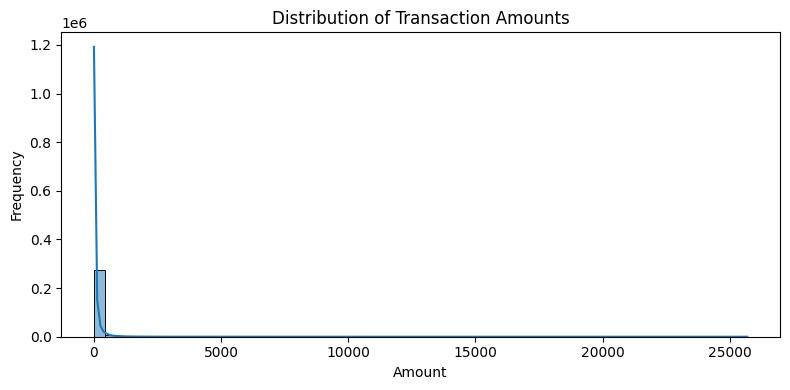

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=60, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount'); plt.ylabel('Frequency')
plt.tight_layout(); plt.show()


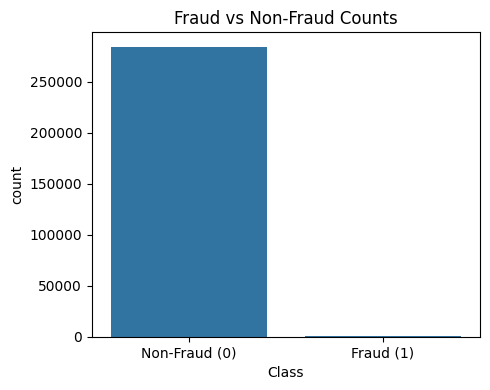

In [28]:
plt.figure(figsize=(5,4))
sns.countplot(x='Class', data=df)
plt.title('Fraud vs Non-Fraud Counts')
plt.xticks([0,1], ['Non-Fraud (0)','Fraud (1)'])
plt.tight_layout(); plt.show()


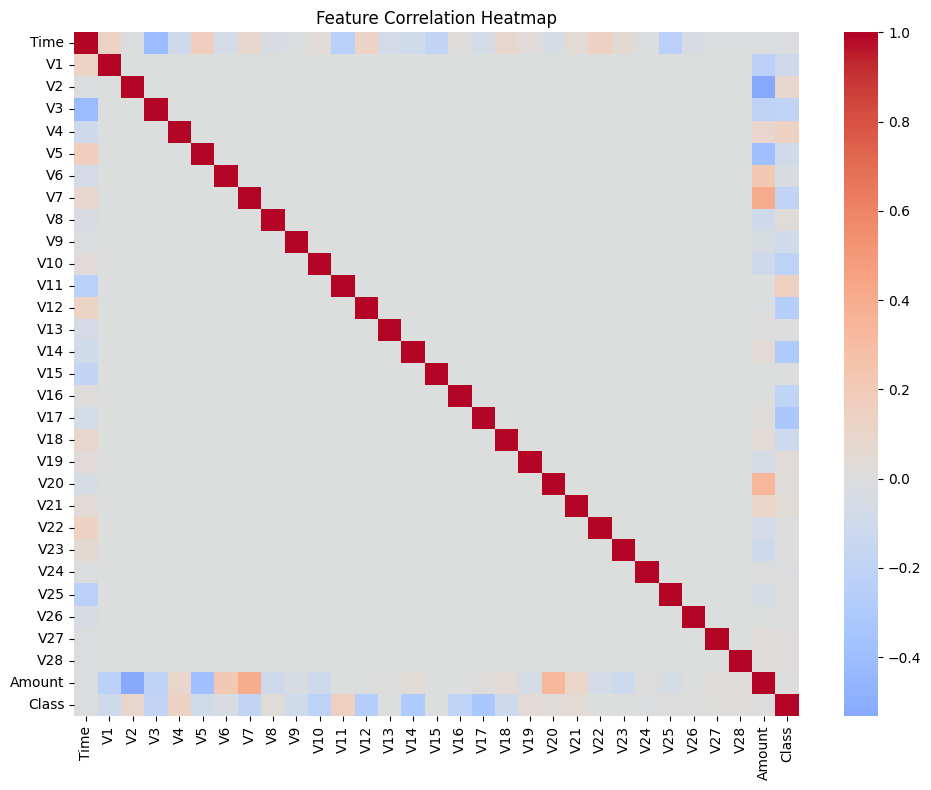

In [29]:
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout(); plt.show()


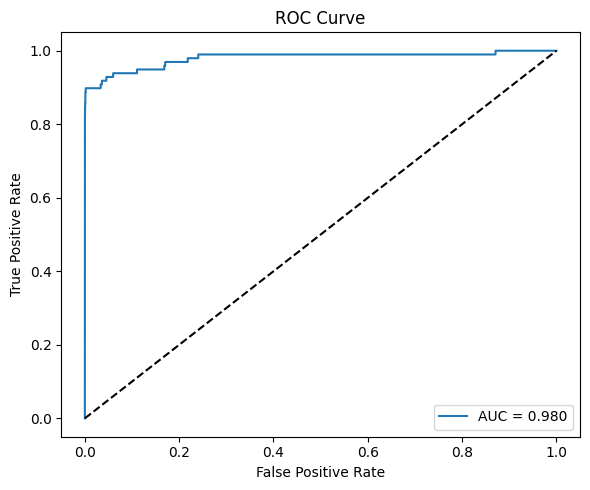

In [30]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(); plt.tight_layout(); plt.show()


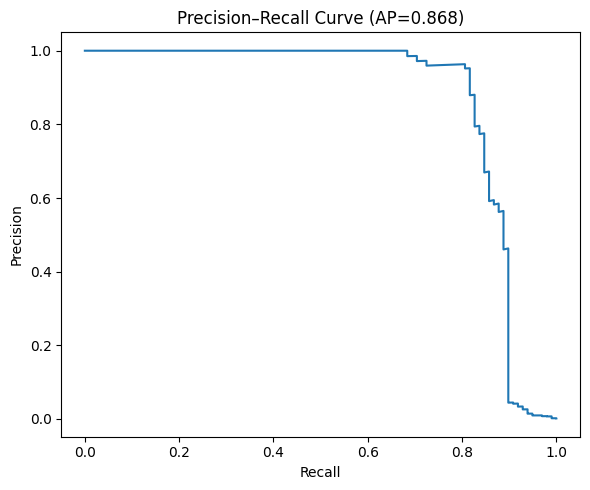

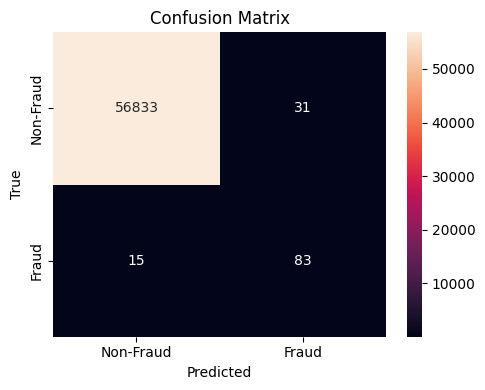

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

prec, rec, _ = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve (AP={ap:.3f})')
plt.tight_layout(); plt.show()

cm = confusion_matrix(y_test, (y_pred_proba >= 0.5).astype(int))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Non-Fraud','Fraud'],
            yticklabels=['Non-Fraud','Fraud'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.tight_layout(); plt.show()


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE:", np.bincount(y_train_res))


After SMOTE: [227451 227451]


In [13]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)

y_pred = xgb.predict(X_test_scaled)
y_pred_proba = xgb.predict_proba(X_test_scaled)[:, 1]


c:\Users\fnuha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:44:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
roc = roc_auc_score(y_test, y_pred_proba)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC–AUC: {roc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


ROC–AUC: 0.9800
Precision: 0.7281
Recall: 0.8469
F1: 0.7830
[[56833    31]
 [   15    83]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.85      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962



In [19]:
# Train XGBoost model and keep it in xgb_clf variable
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_estimators=500,
    max_depth=5,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.8,
)
xgb_clf.fit(X_train_res, y_train_res)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


TreeExplainer failed, switching to permutation explainer.
Reason: could not convert string to float: '[5E-1]'


PermutationExplainer explainer: 2001it [04:33,  7.23it/s]                          


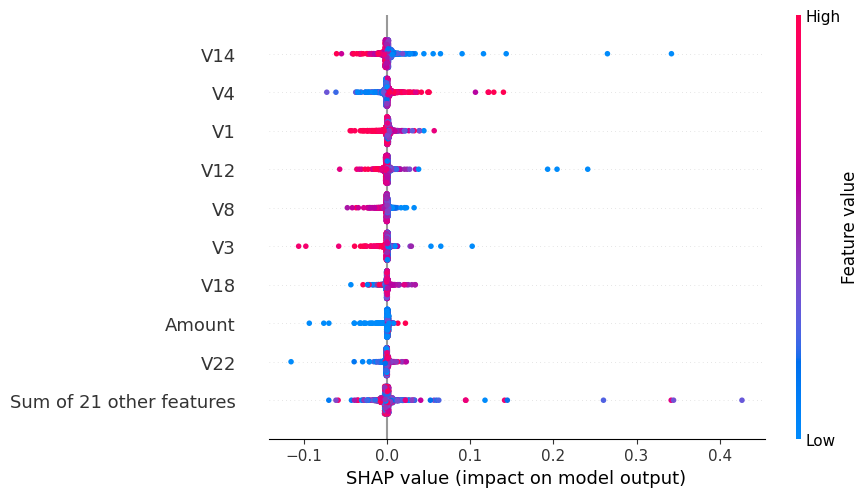

In [25]:
# STEP 8 — SHAP explanations (robust for xgboost 3.x)

import shap
import pandas as pd

# use tuned model if present, else the baseline one you trained
model_for_shap = best_xgb if 'best_xgb' in locals() else xgb_clf

# sample for speed
idx = min(2000, X_test_scaled.shape[0])
X_shap_df = pd.DataFrame(X_test_scaled[:idx], columns=X.columns)

try:
    # ---- Fast path: TreeExplainer on the booster ----
    booster = model_for_shap.get_booster()

    # xgboost 3.x sometimes stores base_score as a string like "[5E-1]" → coerce to float
    try:
        attr = booster.attributes()
        bs = attr.get("base_score", None)
        if isinstance(bs, str) and not bs.replace(".", "", 1).isdigit():
            booster.set_param({"base_score": 0.5})
    except Exception:
        booster.set_param({"base_score": 0.5})

    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(X_shap_df.values)  # TreeExplainer expects ndarray
    shap.summary_plot(shap_values, X_shap_df.values, feature_names=X.columns)

except Exception as e:
    print("TreeExplainer failed, switching to permutation explainer.\nReason:", e)
    # ---- Fallback: permutation explainer on predict_proba for the fraud class (1) ----
    f = lambda data: model_for_shap.predict_proba(data)[:, 1]
    explainer = shap.Explainer(f, X_shap_df, algorithm="permutation")
    sv = explainer(X_shap_df)
    shap.plots.beeswarm(sv)   # global summary (same idea as summary_plot)
